# Explore here

In [1]:
#Importar librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



region	price	year	manufacturer	model	condition	cylinders	fuel	odometer	transmission	drive	size	type	paint_color	description	state

In [2]:
#Cargar datos

#Dataset grande 1
df = pd.read_csv('../data/vehicles.csv', usecols=['region', 'price', 'year','manufacturer','model','condition','cylinders','fuel','odometer','transmission','drive','size','type','paint_color','description','state']) #cargar solo las columnas necesarias

#Dataset datos Ecuador - ignorar Ecuador
#df_ec=pd.read_csv('../data/patiotuerca2023-02-10.csv')

#Dataset 90000 cars 
#df_90k=pd.read_csv('../data/CarsData.csv')



In [3]:
#Explorar datos Dataset grande 1
df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   region        426880 non-null  object 
 1   price         426880 non-null  int64  
 2   year          425675 non-null  float64
 3   manufacturer  409234 non-null  object 
 4   model         421603 non-null  object 
 5   condition     252776 non-null  object 
 6   cylinders     249202 non-null  object 
 7   fuel          423867 non-null  object 
 8   odometer      422480 non-null  float64
 9   transmission  424324 non-null  object 
 10  drive         296313 non-null  object 
 11  size          120519 non-null  object 
 12  type          334022 non-null  object 
 13  paint_color   296677 non-null  object 
 14  description   426810 non-null  object 
 15  state         426880 non-null  object 
dtypes: float64(2), int64(1), object(13)
memory usage: 52.1+ MB


In [4]:
df.head()


,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,transmission,drive,size,type,paint_color,description,state
0,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


In [5]:
df.drop(columns=['description','condition','type','region'],inplace=True) #elimine region para ver si tengo mas datos. 


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         426880 non-null  int64  
 1   year          425675 non-null  float64
 2   manufacturer  409234 non-null  object 
 3   model         421603 non-null  object 
 4   cylinders     249202 non-null  object 
 5   fuel          423867 non-null  object 
 6   odometer      422480 non-null  float64
 7   transmission  424324 non-null  object 
 8   drive         296313 non-null  object 
 9   size          120519 non-null  object 
 10  paint_color   296677 non-null  object 
 11  state         426880 non-null  object 
dtypes: float64(2), int64(1), object(9)
memory usage: 39.1+ MB


In [7]:
# Elimina todas las filas con valores nulos
df_cleaned = df.dropna()

# Muestra el número de filas antes y después de la limpieza
print(f"Filas antes de la limpieza: {len(df)}")
print(f"Filas después de la limpieza: {len(df_cleaned)}")

Filas antes de la limpieza: 426880
Filas después de la limpieza: 94711


In [8]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 94711 entries, 31 to 426836
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         94711 non-null  int64  
 1   year          94711 non-null  float64
 2   manufacturer  94711 non-null  object 
 3   model         94711 non-null  object 
 4   cylinders     94711 non-null  object 
 5   fuel          94711 non-null  object 
 6   odometer      94711 non-null  float64
 7   transmission  94711 non-null  object 
 8   drive         94711 non-null  object 
 9   size          94711 non-null  object 
 10  paint_color   94711 non-null  object 
 11  state         94711 non-null  object 
dtypes: float64(2), int64(1), object(9)
memory usage: 9.4+ MB


In [9]:
df_cleaned.head()

,price,year,manufacturer,model,cylinders,fuel,odometer,transmission,drive,size,paint_color,state
31,15000,2013.0,ford,f-150 xlt,6 cylinders,gas,128000.0,automatic,rwd,full-size,black,al
55,19900,2004.0,ford,f250 super duty,8 cylinders,diesel,88000.0,automatic,4wd,full-size,blue,al
59,14000,2012.0,honda,odyssey,6 cylinders,gas,95000.0,automatic,fwd,full-size,silver,al
65,22500,2001.0,ford,f450,8 cylinders,diesel,144700.0,manual,rwd,full-size,white,al
73,15000,2017.0,dodge,charger rt 4dr sedan,8 cylinders,gas,90000.0,automatic,rwd,mid-size,grey,al


In [10]:
#cambiar floats a int
pd.set_option('display.max_columns', None)
df_cleaned['year'].fillna(0, inplace=True)
df_cleaned['year'] = df_cleaned['year'].astype(int)
df_cleaned['odometer'] = df_cleaned['odometer'].astype(int)
df_cleaned.sample(20)



C:\Users\Juan\AppData\Local\Temp\ipykernel_9908\3109165968.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cleaned['year'].fillna(0, inplace=True)
C:\Users\Juan\AppData\Local\Temp\ipykernel_9908\3109165968.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['year'].fillna(0, inplace=True)
C:\Users\Juan\AppData\Local\Temp\ipyk

,price,year,manufacturer,model,cylinders,fuel,odometer,transmission,drive,size,paint_color,state
339200,10500,2006,ford,f-150,8 cylinders,gas,189688,automatic,4wd,full-size,brown,pa
334505,18346,2013,honda,accord sport,4 cylinders,gas,28237,automatic,fwd,mid-size,silver,pa
160376,10000,2005,bmw,z4 3.0i,6 cylinders,gas,101800,automatic,rwd,compact,grey,ia
362393,15998,2014,mercedes-benz,e-class,6 cylinders,gas,97041,automatic,rwd,mid-size,silver,tn
382524,39998,2014,jeep,wrangler unlimited rubicon,6 cylinders,gas,71200,manual,4wd,full-size,black,tx
207163,5899,2007,subaru,outback,4 cylinders,gas,277000,manual,4wd,mid-size,silver,mi
307941,4500,1973,chrysler,town and country wagon,8 cylinders,gas,200000,automatic,rwd,full-size,blue,ok
227384,39999,2019,mercedes-benz,sprinter,4 cylinders,gas,12554,automatic,rwd,full-size,brown,mt
333069,2350,2001,hyundai,elantra gls,4 cylinders,gas,89000,automatic,rwd,compact,brown,pa
425620,7995,2007,jeep,grand cherokee,6 cylinders,gas,164744,automatic,4wd,full-size,grey,wi


In [11]:
# Assuming your DataFrame is named df
zero_price_listings = (df_cleaned['price'] == 0).sum()

# Print the result
print(f"Number of listings with a price of 0: {zero_price_listings}")

Number of listings with a price of 0: 5803


In [12]:
#Elimina listings con precio 0
df_cleaned = df_cleaned[df_cleaned['price'] != 0]

#Numero de filas despues del drop de listings con precio 0
print(f"Numero de filas despues de drop: {len(df_cleaned)}")

Numero de filas despues de drop: 88908


In [13]:
df_cleaned.info()


<class 'pandas.core.frame.DataFrame'>
Index: 88908 entries, 31 to 426833
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   price         88908 non-null  int64 
 1   year          88908 non-null  int64 
 2   manufacturer  88908 non-null  object
 3   model         88908 non-null  object
 4   cylinders     88908 non-null  object
 5   fuel          88908 non-null  object
 6   odometer      88908 non-null  int64 
 7   transmission  88908 non-null  object
 8   drive         88908 non-null  object
 9   size          88908 non-null  object
 10  paint_color   88908 non-null  object
 11  state         88908 non-null  object
dtypes: int64(3), object(9)
memory usage: 8.8+ MB


In [14]:
df_cleaned.head()

,price,year,manufacturer,model,cylinders,fuel,odometer,transmission,drive,size,paint_color,state
31,15000,2013,ford,f-150 xlt,6 cylinders,gas,128000,automatic,rwd,full-size,black,al
55,19900,2004,ford,f250 super duty,8 cylinders,diesel,88000,automatic,4wd,full-size,blue,al
59,14000,2012,honda,odyssey,6 cylinders,gas,95000,automatic,fwd,full-size,silver,al
65,22500,2001,ford,f450,8 cylinders,diesel,144700,manual,rwd,full-size,white,al
73,15000,2017,dodge,charger rt 4dr sedan,8 cylinders,gas,90000,automatic,rwd,mid-size,grey,al


In [15]:
#Rango de precios
min_price = df_cleaned['price'].min()
max_price = df_cleaned['price'].max()
print(f"Price Range: ${min_price} to ${max_price}\n")

#Rango de Años
min_year = df_cleaned['year'].min()
max_year = df_cleaned['year'].max()
print(f"Year Range: {min_year} to {max_year}\n")

#Tipos de Size
SizeUnique = df_cleaned['size'].unique()
print(f'Unique Sizes: {SizeUnique}')

print("/")

#Tipos de manufacturer
ManufacturerUnique = df_cleaned['manufacturer'].unique()
print(f'Unique Manufacturers: {ManufacturerUnique}')

print("/")

#Tipos de Cylinders
CylindersUnique = df_cleaned['cylinders'].unique()
print(f'Unique Cylinders: {CylindersUnique}')

print("/")

#Tipos de Fuel
FuelUnique = df_cleaned['fuel'].unique()
print(f'Unique Fuel Types: {FuelUnique}')

print("/")

#Rango de Odometer
min_odometer = df_cleaned['odometer'].min()
max_odometer = df_cleaned['odometer'].max()
print(f"Odometer Range: {min_odometer} to {max_odometer}\n")

print("/")

#Tipos de Transmission
TransmissionUnique = df_cleaned['transmission'].unique()
print(f'Unique Transmissions: {TransmissionUnique}')  

print("/")

#Tipos de Drive
DriveUnique = df_cleaned['drive'].unique()
print(f'Unique Drives: {DriveUnique}')

print("/")

#Tipos de Paint Color
PaintColorUnique = df_cleaned['paint_color'].unique()  
print(f'Unique Paint Colors: {PaintColorUnique}')

print("/")

#Tipos de State
StateUnique = df_cleaned['state'].unique()
print(f'Unique States: {StateUnique}')  




Price Range: $1 to $3736928711

Year Range: 1900 to 2022

Unique Sizes: ['full-size' 'mid-size' 'compact' 'sub-compact']
/
Unique Manufacturers: ['ford' 'honda' 'dodge' 'chrysler' 'toyota' 'jeep' 'lexus' 'chevrolet'
 'bmw' 'gmc' 'mercedes-benz' 'mazda' 'ram' 'nissan' 'ferrari' 'audi'
 'mitsubishi' 'infiniti' 'volkswagen' 'kia' 'pontiac' 'hyundai' 'fiat'
 'acura' 'cadillac' 'lincoln' 'jaguar' 'saturn' 'volvo' 'alfa-romeo'
 'buick' 'subaru' 'mini' 'mercury' 'rover' 'porsche' 'harley-davidson'
 'tesla' 'datsun' 'land rover' 'aston-martin']
/
Unique Cylinders: ['6 cylinders' '8 cylinders' '4 cylinders' '5 cylinders' '10 cylinders'
 '3 cylinders' 'other' '12 cylinders']
/
Unique Fuel Types: ['gas' 'diesel' 'hybrid' 'electric' 'other']
/
Odometer Range: 0 to 10000000

/
Unique Transmissions: ['automatic' 'manual' 'other']
/
Unique Drives: ['rwd' '4wd' 'fwd']
/
Unique Paint Colors: ['black' 'blue' 'silver' 'white' 'grey' 'yellow' 'red' 'green' 'brown'
 'purple' 'custom' 'orange']
/
Unique Sta

In [16]:
#Categorias Numericas
numerical_cats = ['price']

# Get descriptive statistics for these columns
print(df[numerical_cats].describe())


              price
count  4.268800e+05
mean   7.519903e+04
std    1.218228e+07
min    0.000000e+00
25%    5.900000e+03
50%    1.395000e+04
75%    2.648575e+04
max    3.736929e+09


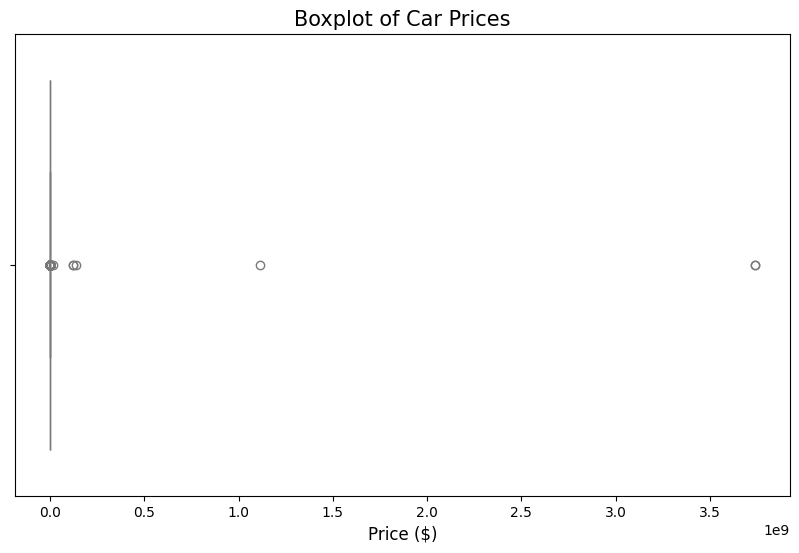

In [17]:
# Create a figure and an axes object
plt.figure(figsize=(10, 6))

# Generate the boxplot
# We use a horizontal orientation for better readability of the price scale
sns.boxplot(x=df_cleaned['price'], color='lightblue')

# Add titles and labels for clarity
plt.title('Boxplot of Car Prices', fontsize=15)
plt.xlabel('Price ($)', fontsize=12)

# Show the plot
plt.show()

Los outliers no me estan dejando ver la data correctamente

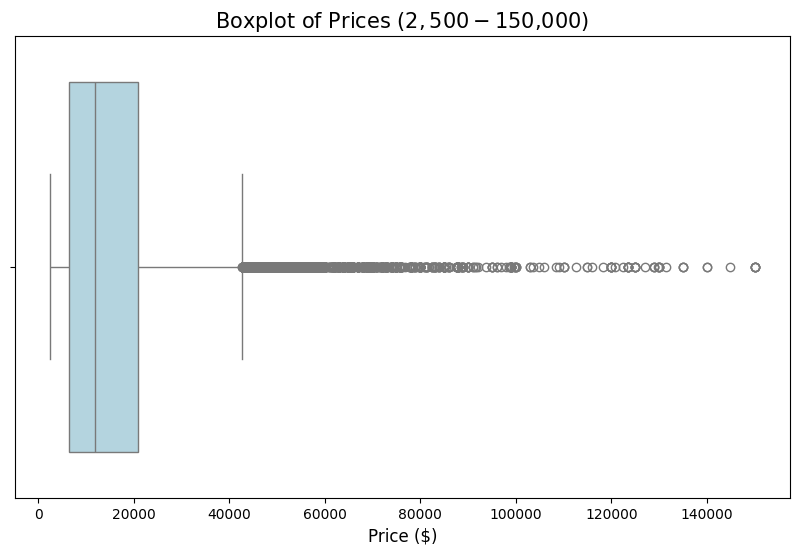

Number of listings in the $2,500 - $200,000 price range: 83244


In [18]:

df_filtered = df_cleaned[(df_cleaned['price'] >= 2500) & (df_cleaned['price'] <= 150000)]

plt.figure(figsize=(10, 6))
sns.boxplot(x=df_filtered['price'], color='lightblue')
plt.title('Boxplot of Prices ($2,500 - $150,000)', fontsize=15)
plt.xlabel('Price ($)', fontsize=12)
plt.show()


count = df_filtered.shape[0]
print(f"Number of listings in the $2,500 - $200,000 price range: {count}")

In [19]:
%matplotlib inline

In [20]:
def plot_manufacturer_bar_chart(df_filtered):
    """
    Generates and displays a bar chart of the top 10 most frequent
    manufacturers.

    Args:
        df (pd.DataFrame): The input DataFrame.
    """
    # 1. Count the occurrences of each manufacturer
    manufacturer_counts = df_filtered['manufacturer'].value_counts().head(10)

    # 2. Set up the plot area
    plt.figure(figsize=(10, 6))

    # 3. Create the bar chart using Seaborn
    sns.barplot(x=manufacturer_counts.index, y=manufacturer_counts.values, palette='viridis')

    # 4. Add titles and labels
    plt.title('Top 10 Most Frequent Car Manufacturers', fontsize=15)
    plt.xlabel('Manufacturer', fontsize=12)
    plt.ylabel('Count', fontsize=12)

    # 5. Rotate labels for readability
    plt.xticks(rotation=45, ha='right')
    
    # 6. Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

C:\Users\Juan\AppData\Local\Temp\ipykernel_9908\273604552.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=manufacturer_counts.index, y=manufacturer_counts.values, palette='viridis')


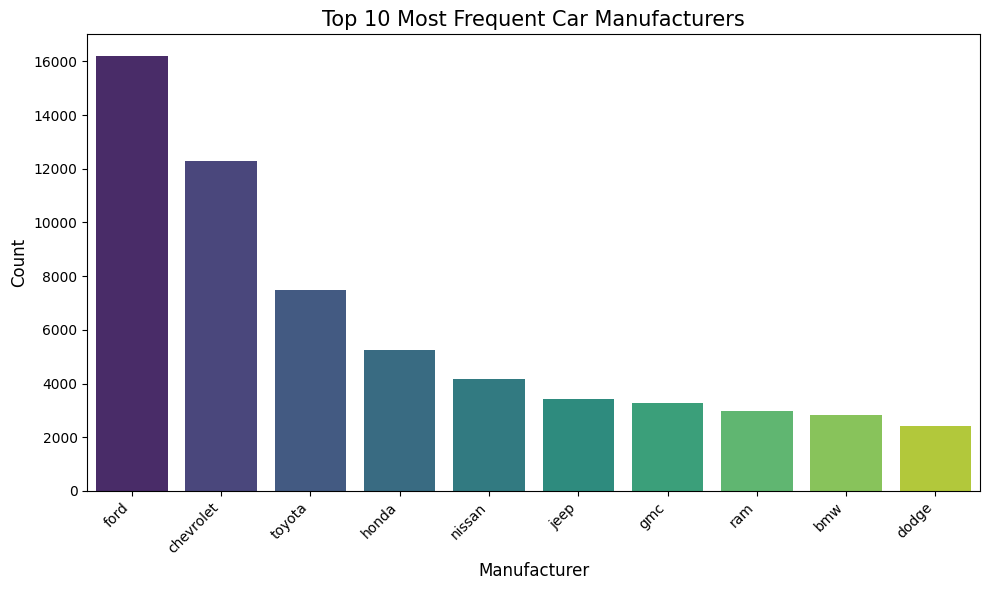

In [22]:
plot_manufacturer_bar_chart(df_filtered)


In [21]:
#funcion para juntar datasets  
#df['year']=df['year'].astype('int64')
#df_90k_p2=df_90k[['model','year','Manufacturer','engineSize','mpg']] / aca solo dejamos las columnas que nos interesan
#df_merged=pd.merge(df,df_90k_p2, how='left', left_on=['model','year','manufacturer'], right_on=['model','year','Manufacturer'])
#df_merged.head()